In [1]:
import sys,os
os.chdir('../../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from subprocess import call 
from DC.importer import *
from DC.processer import *
from DC.main import get_all_events,get_events
from functions import perform_chisq, nufit_params_nsi, nufit_params_nsi_IO
from DC.event_processing import return_precomputed_nsi, get_deltachi, to_hist, get_best_fit
from DC.event_processing import list_of_params_nsi, get_param_list, get_marginalized_array
from scipy.stats import chi2
from src.plotter import save, savethesis
import pickle
from scipy.interpolate import splrep, splev, sproot
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 400
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)
Ebins_2018_midpoints = Ebins_2018[0:-1] +np.diff(Ebins_2018)/2

In [3]:
name = '1x1x1x1x9x9'
track = pickle.load(open(f'./pre_computed/H1_NO_PINGU_1_{name}.p','rb'))
cascade = pickle.load(open(f'./pre_computed/H1_NO_PINGU_0_{name}.p','rb'))
new = np.concatenate((cascade,track), axis=1)
new_name = f'H1_NO_PINGU_1_{name}.p'.replace('_1_','_')
pickle.dump(new,open(f'./pre_computed/{new_name}','wb'))

In [2]:
sigma_a = 0.25
sigma_b = 0.04
f = 1
ndim = 3
livetime = 3*365*24*3600 #Effective livetime table1 DC2019 2.45      

In [3]:
marginalized_arrays_NO=[]
marginalized_arrays_IO=[]
nsi_param_range=[]
N = 10 - 2
sigma_a = 0.25
sigma_b = 0.04
f = 0#.05
for ordering in ['NO','IO']:
    for i,nsi_param in enumerate(['ett','emt','eem','eet']):
        ettN,emtN,eemN,eetN = 0,0,0,0
        if nsi_param == 'ett':
            ettN = 1
        elif nsi_param == 'emt':
            emtN = 1
        elif nsi_param == 'eem':
            eemN = 1
        elif nsi_param == 'eet':
            eetN = 1
        dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N= 5, th23N = 5, 
                                                                                        ett = 5e-2, ettN = N*(ettN)+1,
                                                                                        emt = 2e-2, emtN = N*(emtN)+1,
                                                                                        eem = 2e-1, eemN = N*(eemN)+1,
                                                                                        eet = 2e-1 , eetN = N*(eetN)+1,
                                                                                        IO = True if ordering == 'IO' else False)
        param_dict = nufit_params_nsi_IO if ordering == 'IO' else nufit_params_nsi     
        param_list = list_of_params_nsi(param_dict, dm31_range, th23_range,ett_range, emt_range, eem_range,eet_range) 
        try:
            H1 = pickle.load(open(f'./pre_computed/H1_{ordering}_DC_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime
            H0 = pickle.load(open(f'./pre_computed/H0_{ordering}_DC.p','rb'))*livetime

            marg_array = get_marginalized_array(H1,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, nsi_param, sigma_a,sigma_b, f)
            if ordering == 'NO':
                marginalized_arrays_NO.append(marg_array)
            elif ordering == 'IO':
                marginalized_arrays_IO.append(marg_array)
            param_range = ettN*ett_range + emtN*emt_range + eemN*eem_range + eetN*eet_range #Assumes 3d plot
            nsi_param_range.append(param_range)
        except FileNotFoundError:
            pass #No IO found

$\epsilon_{\tau\tau}$
90CL: [-0.025  0.044]
3sigma: []

$\epsilon_{\tau\tau}$
90CL: [-0.015  0.003]
3sigma: [0.014]

$\epsilon_{\tau\tau}$
90CL: [-0.049  0.055]
3sigma: [-0.121  0.115]

$\epsilon_{\tau\tau}$
90CL: [-0.049  0.132]
3sigma: [-0.166  0.198]



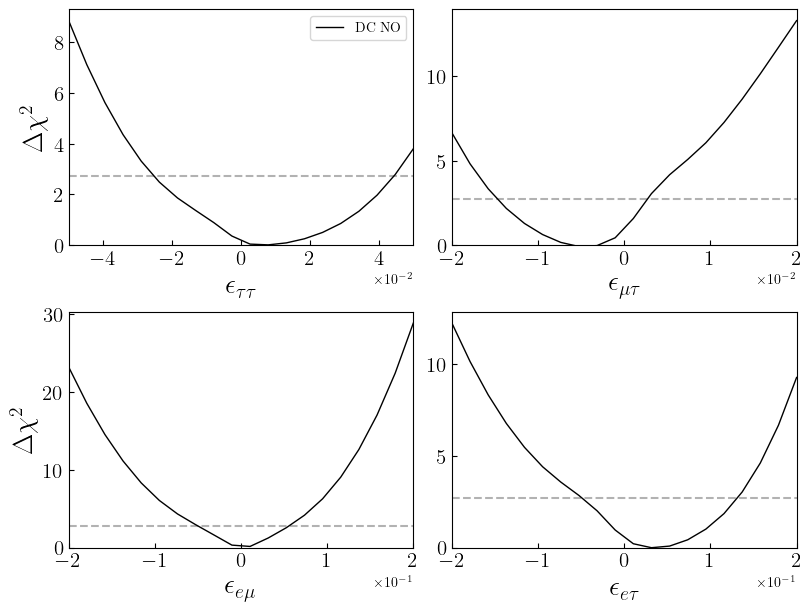

In [19]:
fig, ax = plt.subplots(2,2,figsize=(8,6), constrained_layout=True)
ax = ax.flatten()
demidov_ett = (-0.055, 0.056)
demidov_emt = (-0.023, 0.016)
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
xlabels = [r'$\epsilon_{\tau\tau}$', r'$\epsilon_{\mu\tau}$', r'$\epsilon_{e\mu}$', r'$\epsilon_{e\tau}$']
demidovs =[demidov_ett, demidov_emt, demidov_eem, demidov_eet]
for i in range(4):
    finer_e_range = np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),20)
    interpolated_e = splev(np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),20),splrep(nsi_param_range[i], marginalized_arrays_NO[i]))
    #ax[i].plot(nsi_param_range[i], marginalized_arrays_NO[i], label='DC NO', color='k', lw=1)
    ax[i].plot(finer_e_range, interpolated_e, label='DC NO', color='k', lw=1)
    #ax[i].plot(nsi_param_range[i], marginalized_arrays_IO[i], label='IO', color='green')
    ax[i].axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

    #ax[i].axvline(demidovs[i][0], alpha=0.6,c='black', label=r'Demidov NO')
    #ax[i].axvline(demidovs[i][1], alpha=0.6,c='black')
    ax[i].set_ylim(bottom=0)
    ax[i].set_xlim((nsi_param_range[i].min(), nsi_param_range[i].max()))
    ax[i].set_xlabel(xlabels[i], fontsize=20)
    ax[i].tick_params(labelsize=15,axis='both', direction='in', which='both')
    ax[i].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    cl_90_bounds = splrep(nsi_param_range[i], marginalized_arrays_NO[i]- chi2.ppf(0.9,1))
    three_sigma_bounds = splrep(nsi_param_range[i], marginalized_arrays_NO[i]- chi2.ppf(0.9973,1))
    print(xlabels[i]+'\n'+f'90CL: {sproot(cl_90_bounds)}\n'+f'3sigma: {sproot(three_sigma_bounds)}\n')
ax[0].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax[2].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax[0].legend()
save(fig, 'DC_3D_NO')
savethesis(fig, 'DC_3D_NO')

In [22]:
spl = splrep(ett_range,chisq_ett - chi2.ppf(0.9,1))
sproot(spl)

array([-0.025,  0.044])

In [7]:
ett_range

array([0.])

In [14]:
splev(np.linspace(nsi_param_range[0].min(),nsi_param_range[0].max(),20),splrep(nsi_param_range[0], marginalized_arrays_NO[0]))

array([8.867e+00, 7.126e+00, 5.625e+00, 4.357e+00, 3.313e+00, 2.484e+00, 1.858e+00, 1.364e+00, 8.842e-01, 3.526e-01, 3.438e-02, 4.502e-03, 8.254e-02, 2.450e-01, 4.963e-01, 8.502e-01, 1.332e+00,
       1.967e+00, 2.781e+00, 3.800e+00])

In [9]:
ordering = 'NO'
dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N= 5, th23N = 5, 
                                                                                        ett = 5e-2, ettN = 10,
                                                                                        emt = 2e-2, emtN = 1,
                                                                                        eem = 2e-1, eemN = 1,
                                                                                        eet = 2e-1 , eetN = 1,
                                                                                        IO = True if ordering == 'IO' else False)
param_dict = nufit_params_nsi_IO if ordering == 'IO' else nufit_params_nsi     
param_list = list_of_params_nsi(param_dict, dm31_range, th23_range,ett_range, emt_range, eem_range,eet_range) 

H1 = pickle.load(open(f'./pre_computed/H1_{ordering}_DC_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime
H0 = pickle.load(open(f'./pre_computed/H0_{ordering}_DC.p','rb'))*livetime

#marg_array = get_marginalized_array(param_list, 'ett')

In [6]:
#H1 = np.swapaxes(H1,2,3)
#pickle.dump(H1,open(f'./pre_computed/H1_{ordering}_DC_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','wb'))

In [11]:
sigma_a = 0.25
sigma_b = 0.04
f = 0#.05
chisq,  best_fit_index = get_deltachi([H for H in H1],0,[sigma_a,sigma_b],f,x0=[1,0])

reshaped_chisq = chisq.reshape(len(eet_range),
                               len(eem_range),
                               len(emt_range), 
                               len(ett_range), 
                               len(th23_range), 
                               len(dm31_range)) #reshaped_chisq[eet,eem,emt,emm,th23,dm31]
minimum_oscillation = np.min(reshaped_chisq,axis=(0,1,2,3)).reshape(1,1,1,1,len(th23_range),len(dm31_range)) #Marginalize osc params
deltachi = reshaped_chisq - minimum_oscillation


best_eet_index,best_eem_index,best_emt_index,best_ett_index,best_th23_index, best_dm31_index = np.unravel_index(best_fit_index,deltachi.shape)
best_dm31, best_th23, best_ett, best_emt, best_eem, best_eet = (dm31_range[best_dm31_index], 
                                                                th23_range[best_th23_index],
                                                                ett_range[best_ett_index],
                                                                emt_range[best_emt_index],
                                                                eem_range[best_eem_index],
                                                                eet_range[best_eet_index])
best_fit_params = param_list[best_fit_index]

assert best_fit_params['dm_31'] == best_dm31 
assert best_fit_params['theta_23'] == best_th23
assert best_fit_params['e_tt'] == best_ett
assert best_fit_params['e_mt'] == best_emt
assert best_fit_params['e_em'] == best_eem
assert best_fit_params['e_et'] == best_eet

marginalized_deltachi = deltachi[:,:,:,:,best_th23_index,best_dm31_index].T
deltachi_ett = marginalized_deltachi[:,best_emt_index, best_eem_index, best_eet_index]
deltachi_emt = marginalized_deltachi[best_ett_index,:, best_eem_index, best_eet_index]
deltachi_eem = marginalized_deltachi[best_ett_index,best_emt_index, :, best_eet_index]
deltachi_eet = marginalized_deltachi[best_ett_index,best_emt_index, best_eem_index, :]

In [20]:
deltachi[:,:,:,:,best_th23_index,best_dm31_index]

array([[[[8.867, 4.696, 2.192, 0.81 , 0.146, 0.   , 0.377, 1.496, 3.8  ]]]])

In [38]:
deltachi[:,:,:,:,3,2]

array([[[[11.37 ,  6.525,  3.42 ,  1.53 ,  0.475,  0.   ,  0.064,  0.825,  2.611]]]])

In [23]:
th23_range*180/np.pi

array([40.1  , 43.967, 47.833, 49.2  , 51.7  ])

In [31]:
dm31_range[2]

0.002517

In [34]:
th23_range*180/np.pi

array([40.1  , 43.967, 47.833, 49.2  , 51.7  ])

In [37]:
get_param_list(dm31N= 1, th23N = 3, 
                                                                                        ett = 5e-2, ettN = 1,
                                                                                        emt = 2e-2, emtN = 1,
                                                                                        eem = 2e-1, eemN = 1,
                                                                                        eet = 2e-1 , eetN = 1,
                                                                                        IO = True if ordering == 'IO' else False)[1]*180/np.pi

array([40.1, 49.2, 51.7])

In [7]:
demidov_ett = (-0.055, 0.056)
demidov_emt = (-0.023, 0.016)
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
marginalized_deltachi =get_marginalized_array(param_list, 'ett')

TypeError: get_marginalized_array() missing 10 required positional arguments: 'th23_range', 'ett_range', 'emt_range', 'eem_range', 'eet_range', 'param_list', 'nsi_param', 'sigma_a', 'sigma_b', and 'f'

In [91]:
get_best_fit(marginalized_deltachi, ett_range,0.9)

(-0.028, 0.044)

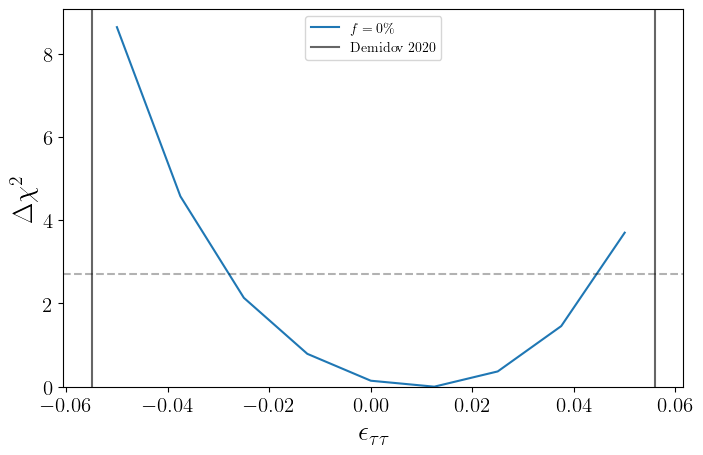

In [93]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.plot(ett_range, marginalized_deltachi,label=r'$f = 0\%$')
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
plt.axvline(demidov_ett[0], alpha=0.6,c='black', label=r'Demidov 2020')
plt.axvline(demidov_ett[1], alpha=0.6,c='black')


#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
plt.ylim(bottom=0)
#plt.xlim((ett_range.min(), ett_range.max()))
plt.xlabel(r'$\epsilon_{\tau\tau}$', fontsize=20)
plt.ylabel(r'$\Delta \chi^2$', fontsize=20)
plt.tick_params(labelsize=15)
plt.legend()
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save(fig, 'DC_3D_ett')

(-0.015, 0.005)


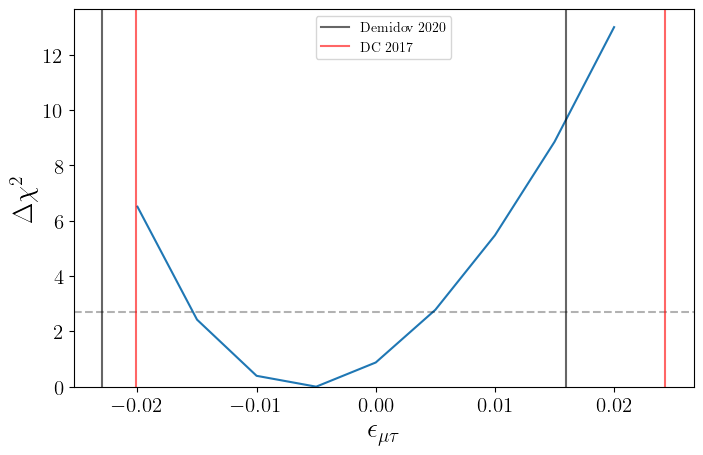

In [30]:
salvado = (-6e-3*3, 5.4e-3*3)
dc_2017 = (-6.7e-3*3, 8.1e-3*3)

fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.plot(emt_range, deltachi_emt)
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

plt.axvline(demidov_emt[0], alpha=0.6,c='black', label=r'Demidov 2020')
plt.axvline(demidov_emt[1], alpha=0.6,c='black')

plt.axvline(dc_2017[0], alpha=0.6,c='red', label=r'DC 2017')
plt.axvline(dc_2017[1], alpha=0.6,c='red')

plt.ylim(bottom=0)

plt.xlabel(r'$\epsilon_{\mu\tau}$', fontsize=20)
plt.ylabel(r'$\Delta \chi^2$', fontsize=20)
plt.tick_params(labelsize=15)
plt.legend()
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
print(get_best_fit(deltachi=deltachi_emt , p_range = emt_range, cl=0.9))
#save(fig, 'DC_3D_emt')

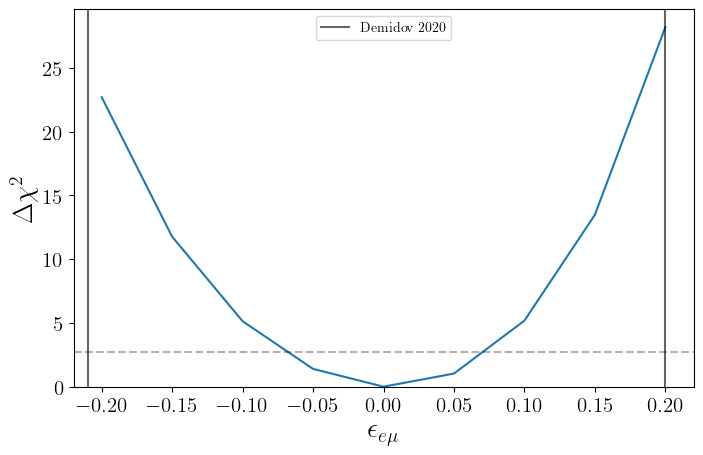

In [76]:
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.plot(eem_range, marginalized_deltachi)
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

plt.axvline(demidov_eem[0], alpha=0.6,c='black', label=r'Demidov 2020')
plt.axvline(demidov_eem[1], alpha=0.6,c='black')


plt.ylim(bottom=0)

plt.xlabel(r'$\epsilon_{e\mu}$', fontsize=20)
plt.ylabel(r'$\Delta \chi^2$', fontsize=20)
plt.tick_params(labelsize=15)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend()
#print(get_best_fit(deltachi=deltachi_eem , p_range = eem_range, cl=0.9))
#save(fig, 'DC_3D_eem')

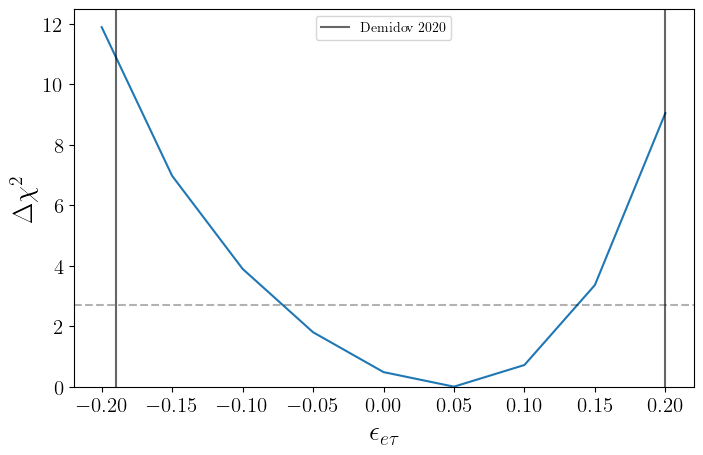

In [73]:
demidov_eet = (-0.19, 0.20)
fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.plot(eet_range, marginalized_deltachi)
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')

plt.axvline(demidov_eet[0], alpha=0.6,c='black', label=r'Demidov 2020')
plt.axvline(demidov_eet[1], alpha=0.6,c='black')


plt.ylim(bottom=0)

plt.xlabel(r'$\epsilon_{e\tau}$', fontsize=20)
plt.ylabel(r'$\Delta \chi^2$', fontsize=20)
plt.tick_params(labelsize=15)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend()
#print(get_best_fit(deltachi=deltachi_eet , p_range = eet_range, cl=0.9))
#save(fig, 'DC_3D_eet')

<ipython-input-151-487847d1795f>:2: UserWarning: The following kwargs were not used by contour: 'label'
  no_err = ax.contour(marginalized_deltachi.T,levels = [chi2.ppf(q=0.9, df = 2)], label='No exp. uncert.')


"\nfmt_noerr = {}\nstrs = ['f=0 \\%']#,'f = 5 \\%']\nfor l, s in zip(no_err.levels, strs):\n    fmt_noerr[l] = s\n\nfmt_fiverr = {}\nstrs = ['f=5 \\%']\nfor l, s in zip(five_err.levels, strs):\n    fmt_fiverr[l] = s\n\nax.clabel(no_err, no_err.levels, inline=True, fmt=fmt_noerr, fontsize=10)\nax.clabel(five_err, five_err.levels, inline=True, fmt=fmt_fiverr, fontsize=10)\n"

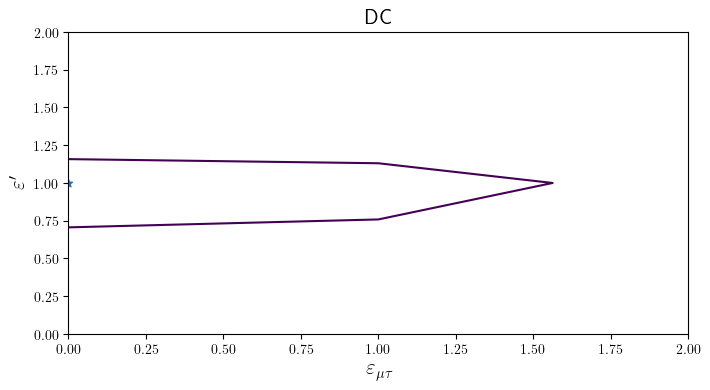

In [151]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
no_err = ax.contour(marginalized_deltachi.T,levels = [chi2.ppf(q=0.9, df = 2)], label='No exp. uncert.')
#five_err = ax.contour(deltachi1.T,levels = [chi2.ppf(q=0.9, df = 2)], label='5 \% exp. uncert.', color='orange')
ax.scatter(best_emt_index,best_emm_index, marker='*')
#_=ax.set_xticklabels(labels=np.round(emt_range,3))
#_=ax.set_yticklabels(labels=np.round(emm_range,3))
ax.set_xlabel(r'$\varepsilon_{\mu\tau}$', fontsize=15)
ax.set_ylabel(r'$\varepsilon^\prime$', fontsize=15)
plt.title(r'DC', fontsize=15)

'''
fmt_noerr = {}
strs = ['f=0 \%']#,'f = 5 \%']
for l, s in zip(no_err.levels, strs):
    fmt_noerr[l] = s

fmt_fiverr = {}
strs = ['f=5 \%']
for l, s in zip(five_err.levels, strs):
    fmt_fiverr[l] = s

ax.clabel(no_err, no_err.levels, inline=True, fmt=fmt_noerr, fontsize=10)
ax.clabel(five_err, five_err.levels, inline=True, fmt=fmt_fiverr, fontsize=10)
'''

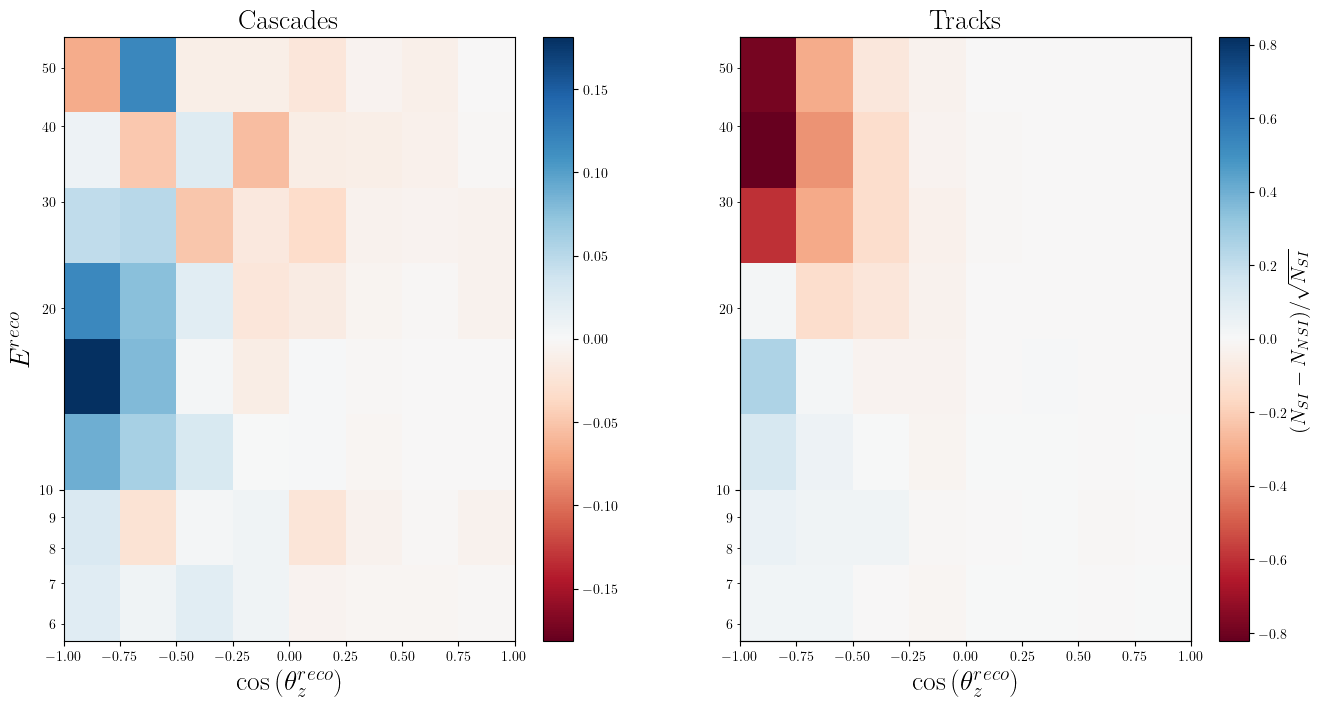

In [157]:
from matplotlib.colors import CenteredNorm
N_NSI_left = H1[emt_min_index]
N_NSI_right = H1[emt_max_index]
N_SI = H1[emt_SI_index] #H0
pull_min = (N_SI - N_NSI_left)/np.sqrt(N_SI)
pull_max = (N_SI - N_NSI_right)/np.sqrt(N_SI)
pull_diff = (N_NSI_left - N_NSI_right)/np.sqrt(N_SI)

titles = [r'$\mathrm{Cascades}$', r'$\mathrm{Tracks}$']
fig, ax = plt.subplots(1,2,figsize=(16,8))
for pid in [0,1]:
    ax[pid].set_title(titles[pid], fontsize=20)
    im = ax[pid].pcolormesh(zbins_2018,Ebins_2018, pull_min[pid], cmap='RdBu', norm= CenteredNorm(0))
    ax[pid].set_yscale('log')
    plt.colorbar(im, ax=ax[pid])
    ax[pid].set_xlabel(r'$\cos{(\theta^{reco}_z)}$', fontsize=20)
    
    ax[pid].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[pid].get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    #ax[pid].ticklabel_format(style='sci',axis='y')
    #ax[pid].tick_params(which='both',labelsize=13)
    ax[pid].set_yticks([10])
ax[0].set_ylabel(r'$E^{reco}$', fontsize=20)
ax2 = ax[1].twinx()
ax2.set_yticks([])
ax2.set_ylabel(r'$(N_{SI} - N_{NSI})/\sqrt{N_{SI}}$', fontsize=15, labelpad= 70)
#plt.suptitle(r'$[N(\epsilon_{\mu\tau}^-) - N(\epsilon_{\mu\tau}^+)]/\sqrt{N_{SI}}$ DC',fontsize=20)
fig.savefig('latex/article/figures/DC_event_pulls.pdf')
from subprocess import call 
_ = call('pdfcrop latex/article/figures/DC_event_pulls.pdf latex/article/figures/DC_event_pulls.pdf')

In [2]:
from plotter import P_over_E_parameter
E_range = np.logspace(0,2,300)
plot_params = list_of_params_nsi(nufit_params_nsi,dm31_range=[nufit_params_nsi['dm_31']],th23_range=[nufit_params_nsi['theta_23']], emm_range= np.array([0]), emt_range= np.array([-1e-2,0,1e-2]))

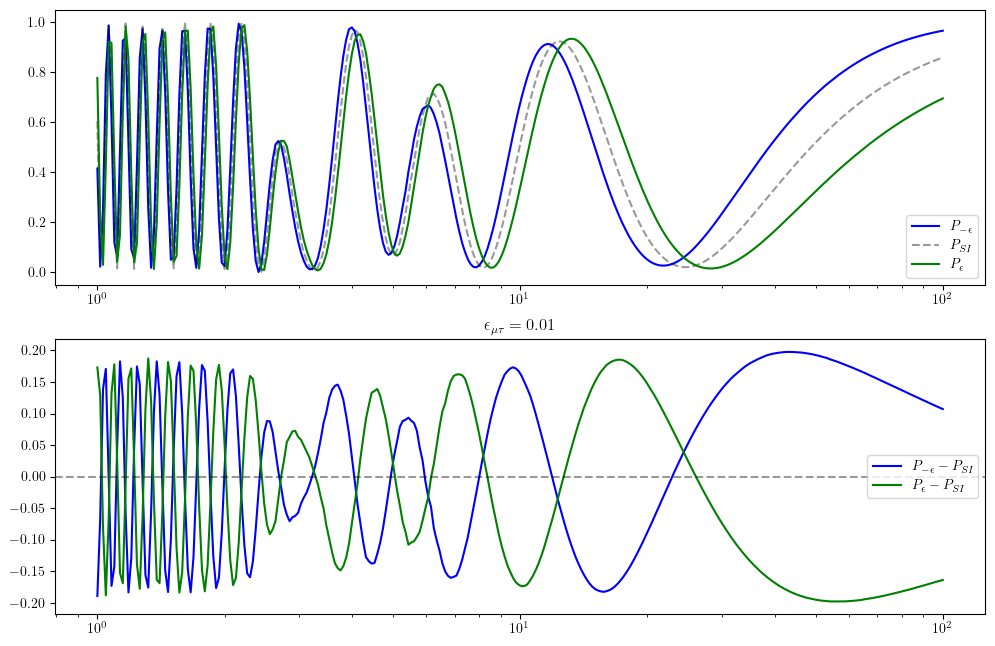

In [33]:
#Pm = P_over_E_parameter('m', param_dict_list=plot_params, E=E_range, zenith = -1, ndim = 3, anti=False, nsi=True)
#Pmm = Pm[:,1,:]
fig, ax = plt.subplots(2,1, figsize=(12,8))
ax[0].plot(E_range, Pmm[0] , c='blue', label=r'$P_{-\epsilon} $')
ax[0].plot(E_range, Pmm[1], ls='dashed', alpha=0.4, c='black', label=r'$P_{SI} $')
ax[0].plot(E_range, Pmm[2], c='green', label=r'$P_{\epsilon}$')
ax[0].legend()
ax[0].set_xscale('log')

ax[1].plot(E_range, Pmm[0] - Pmm[1], c='blue', label=r'$P_{-\epsilon} - P_{SI}$')
#plt.plot(E_range, Pmm[1], c='black')
ax[1].plot(E_range, Pmm[2] - Pmm[1], c='green', label=r'$P_{\epsilon} - P_{SI}$')
ax[1].axhline(0, ls='dashed', alpha=0.4, c='black')
ax[1].set_xscale('log')
plt.title(r'$\epsilon_{\mu\tau} = 0.01$')
ax[1].legend()

In [2]:
from src.plotter import nsi_oscillogram, nsi_flux_oscillogram

z_range = np.linspace(-1,0,500)
E_range = np.logspace(0,2,500)

#Pex_neg, Pmx_neg, Paeax_neg,Pamax_neg = nsi_oscillogram(E_range=E_range, z_range=z_range, params= plot_params[0])
#Pex_si, Pmx_si, Paeax_si,Pamax_si = nsi_oscillogram(E_range=E_range, z_range=z_range, params= plot_params[1])
#Pex_pos, Pmx_pos, Paeax_pos,Pamax_pos = nsi_oscillogram(E_range=E_range, z_range=z_range, params= plot_params[2])

Pmx_neg = pickle.load(open('./pre_computed/Pmx_neg.p','rb'))
Pmx_pos = pickle.load(open('./pre_computed/Pmx_pos.p','rb'))
#fluxratio_neg = nsi_flux_oscillogram(E_range=E_range, z_range=z_range, params= plot_params[0])
#fluxratio_pos = nsi_flux_oscillogram(E_range=E_range, z_range=z_range, params= plot_params[2])

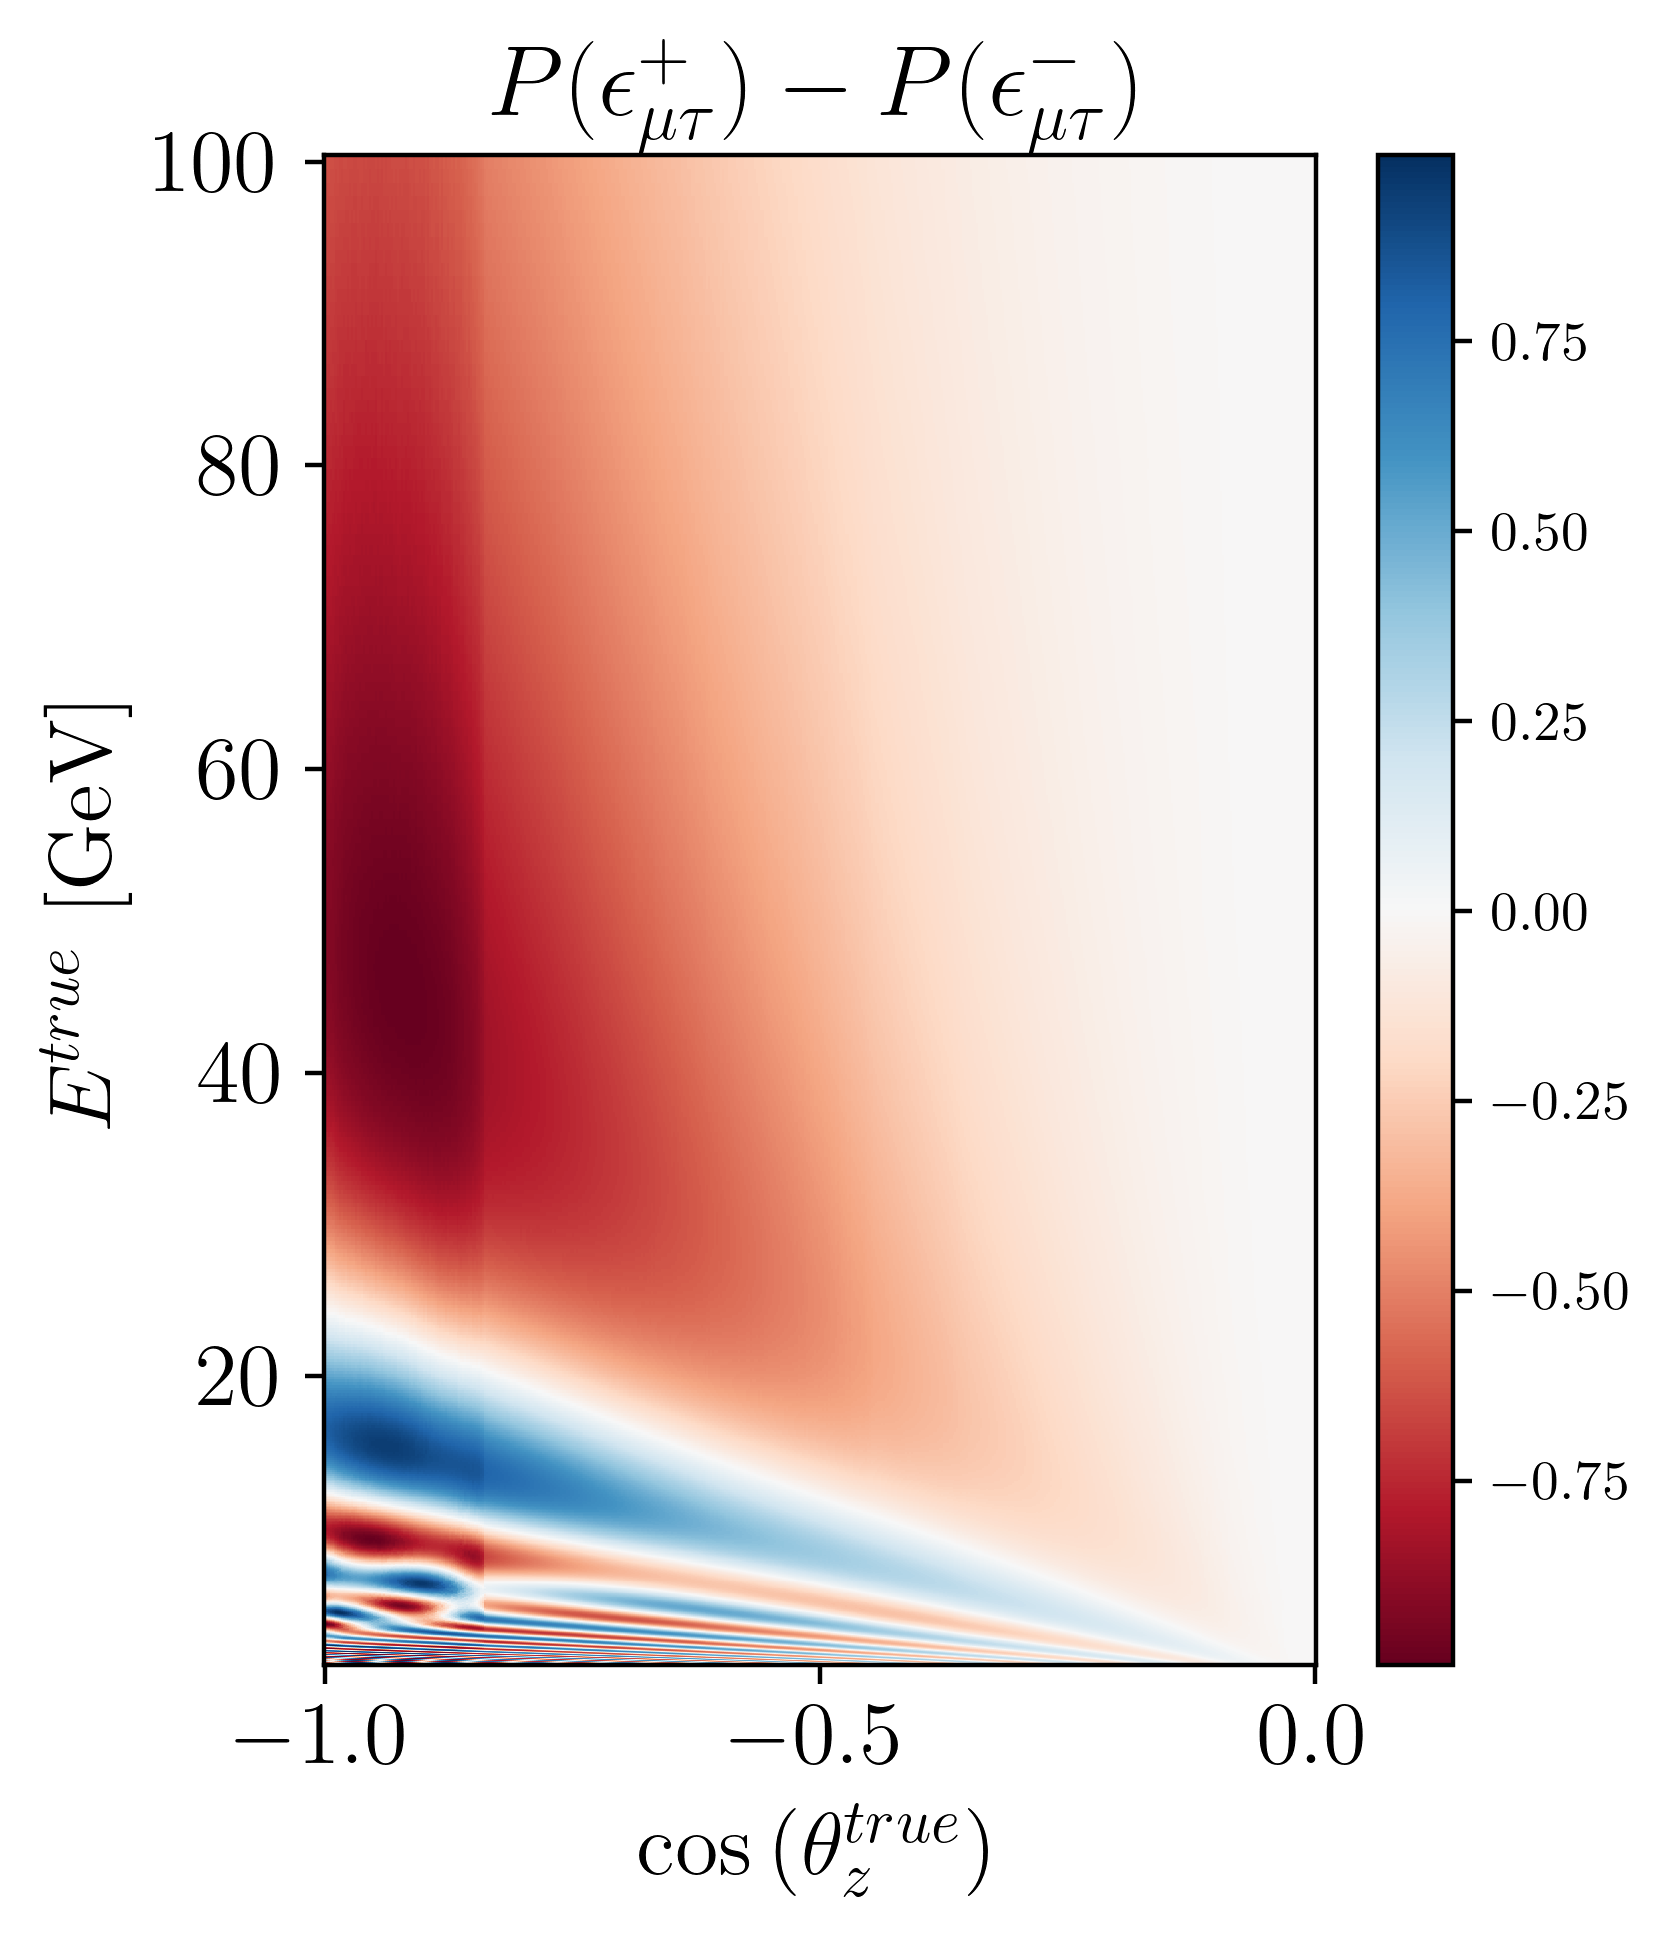

In [7]:
import matplotlib.colors as colors

fig, ax = plt.subplots(1,1, figsize=(4,5))
c=ax.pcolormesh(z_range, E_range, Pmx_pos[1].T - Pmx_neg[1].T,cmap='RdBu',edgecolor=None, shading = 'auto', rasterized=True)#,norm=colors.CenteredNorm(1))
ax.set_title(r'$P(\epsilon^+_{\mu\tau}) - P(\epsilon^-_{\mu\tau})$', fontsize=18)
ax.set_xlabel(r'$\cos{(\theta^{true}_z)}$', fontsize=16)
ax.tick_params(labelsize=16)
ax.set_ylabel(r'$E^{true}\,\,\mathrm{[GeV]}$', fontsize=16)
cbar = fig.colorbar(c, ax=ax)
plt.savefig('./article/figures/Pmm_asymmetry.pdf', bbox_inches="tight")

In [86]:
from plotter import P_over_E_parameter
E_range = np.logspace(0,2,100)
plot_params = list_of_params_nsi(nufit_params_nsi,dm31_range=[nufit_params_nsi['dm_31']],th23_range=[nufit_params_nsi['theta_23']], emt_range= np.array([0]), emm_range= np.array([-1e-2,0,1e-2]))
Pm = P_over_E_parameter('e', param_dict_list=plot_params, E=E_range, zenith = -1, ndim = 3, anti=False, nsi=True)

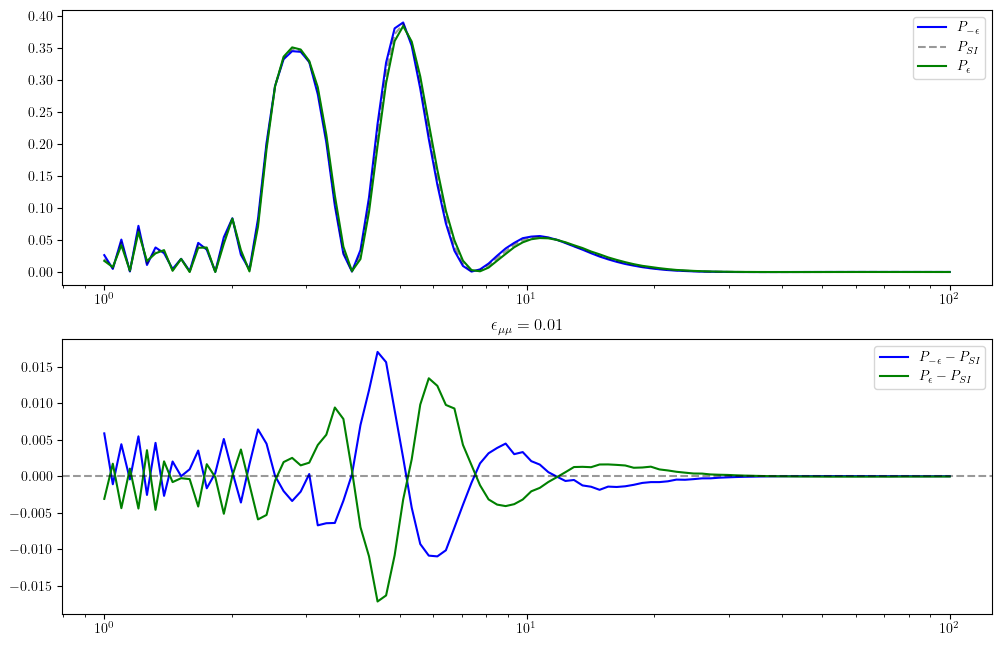

In [83]:
Pmm = Pm[:,2,:]
fig, ax = plt.subplots(2,1, figsize=(12,8))
ax[0].plot(E_range, Pmm[0] , c='blue', label=r'$P_{-\epsilon} $')
ax[0].plot(E_range, Pmm[1], ls='dashed', alpha=0.4, c='black', label=r'$P_{SI} $')
ax[0].plot(E_range, Pmm[2], c='green', label=r'$P_{\epsilon}$')
ax[0].legend()
ax[0].set_xscale('log')

ax[1].plot(E_range, Pmm[0] - Pmm[1], c='blue', label=r'$P_{-\epsilon} - P_{SI}$')
#plt.plot(E_range, Pmm[1], c='black')
ax[1].plot(E_range, Pmm[2] - Pmm[1], c='green', label=r'$P_{\epsilon} - P_{SI}$')
ax[1].axhline(0, ls='dashed', alpha=0.4, c='black')
ax[1].set_xscale('log')
plt.title(r'$\epsilon_{\mu\mu} = 0.01$')
ax[1].legend()

In [87]:
E_range = np.logspace(0,2,5)
Pex_neg, Pmx_neg, Paeax_neg,Pamax_neg = nsi_oscillogram(E_range=E_range, z_range=z_range, params= plot_params[0])
Pex_si, Pmx_si, Paeax_si,Pamax_si = nsi_oscillogram(E_range=E_range, z_range=z_range, params= plot_params[1])
Pex_pos, Pmx_pos, Paeax_pos,Pamax_pos = nsi_oscillogram(E_range=E_range, z_range=z_range, params= plot_params[2])

fluxratio_neg = nsi_flux_oscillogram(E_range=E_range, z_range=z_range, params= plot_params[0])
fluxratio_pos = nsi_flux_oscillogram(E_range=E_range, z_range=z_range, params= plot_params[2])

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True)
norm_factor = np.array([0.9,0.9])
back_factor = np.array([0.15,1])
for pid in [0,1]:
    ax[0,pid].step(Ebins_2018, to_hist(no_osc_paper[pid]), color = 'blue', ls = '--', alpha = 0.6, label='DC no osc.', where='post')
    ax[0,pid].step(Ebins_2018, to_hist(norm_factor[pid]*np.sum(no_osc[pid],axis=1)*livetime + back_factor[pid]*np.sum(background[pid],axis=1)), color = 'green', ls='--', alpha=0.6, label='Me no osc.', where='post')
    ax[0,pid].set_xscale('log')
    ax[1,pid].step(Ebins_2018, to_hist(H0_paper[pid]), color = 'blue', label=r'DC $3\nu$', where='post')
    ax[1,pid].step(Ebins_2018, to_hist(norm_factor[pid]*np.sum(H0[pid],axis=1)), color = 'green', label=r'Me $3\nu$', where='post')
    ax[1,pid].set_xscale('log')

ax[0,0].set_title('Cascades',fontsize=20)
ax[0,1].set_title('Tracks',fontsize=20)
ax[1,0].set_xlabel('E [GeV]')
ax[1,1].set_xlabel('E [GeV]')
ax[0,0].legend()
ax[1,0].legend()
fig.tight_layout()